<a href="https://colab.research.google.com/github/Sairam-Kesanapalli/ML-project/blob/main/OUTPUT_FILES/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 🔵 BLOCK 1 — INSTALL & IMPORTS
!pip install -q ucimlrepo joblib matplotlib scikit-learn pandas numpy seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

os.makedirs("/content/output", exist_ok=True)
print("Environment ready.")


Environment ready.


In [ ]:
#@title 🔵 BLOCK 2 — LOAD STATLOG SHUTTLE DATASET
data = fetch_ucirepo(id=148)
X = data.data.features.copy()
y = data.data.targets.squeeze().copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class distribution:\n", y.value_counts())


X shape: (58000, 7)
y shape: (58000,)
Class distribution:
 class
1    45586
4     8903
5     3267
3      171
2       50
7       13
6       10
Name: count, dtype: int64


In [ ]:
#@title 🔵 BLOCK 3 — TRAIN/TEST SPLIT + STANDARDIZATION
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler_sh = StandardScaler().fit(X_train)
X_train_s = scaler_sh.transform(X_train)
X_test_s  = scaler_sh.transform(X_test)

joblib.dump(scaler_sh, "/content/output/scaler_gmm_shuttle.joblib")
joblib.dump(list(X.columns), "/content/output/training_columns_shuttle.joblib")

print("Scaler + training column list saved.")


Scaler + training column list saved.


In [ ]:
#@title 🔵 BLOCK 4 — TRAIN GMM MODELS (ONE PER CLASS)
classes = sorted(y_train.unique())
gmms_sh = {}

for c in classes:
    Xc = X_train_s[y_train == c]
    n_comp = 1 if len(Xc) < 50 else 2
    gmm = GaussianMixture(
        n_components=n_comp,
        covariance_type='full',
        random_state=42,
        max_iter=200
    )
    gmm.fit(Xc)
    gmms_sh[c] = gmm
    print(f"Trained GMM for class {c}  (n_components={n_comp})")

joblib.dump(gmms_sh, "/content/output/gmm_class_model_shuttle.joblib")
print("Saved all GMMs.")


Trained GMM for class 1  (n_components=2)
Trained GMM for class 2  (n_components=1)
Trained GMM for class 3  (n_components=2)
Trained GMM for class 4  (n_components=2)
Trained GMM for class 5  (n_components=2)
Trained GMM for class 6  (n_components=1)
Trained GMM for class 7  (n_components=1)
Saved all GMMs.


GMM Classification Accuracy: 0.7965517241379311

Classification report:
               precision    recall  f1-score   support

           1       1.00      0.79      0.88      9117
           2       0.01      1.00      0.01        10
           3       0.05      0.59      0.10        34
           4       0.80      0.84      0.82      1781
           5       1.00      0.77      0.87       653
           6       0.00      0.00      0.00         2
           7       0.01      1.00      0.02         3

    accuracy                           0.80     11600
   macro avg       0.41      0.71      0.39     11600
weighted avg       0.96      0.80      0.87     11600


Confusion matrix:
 [[7205  925  320  364    0    8  295]
 [   0   10    0    0    0    0    0]
 [   6    3   20    1    0    0    4]
 [   3  246   21 1501    0   10    0]
 [   2  139   10    0  501    1    0]
 [   0    1    1    0    0    0    0]
 [   0    0    0    0    0    0    3]]


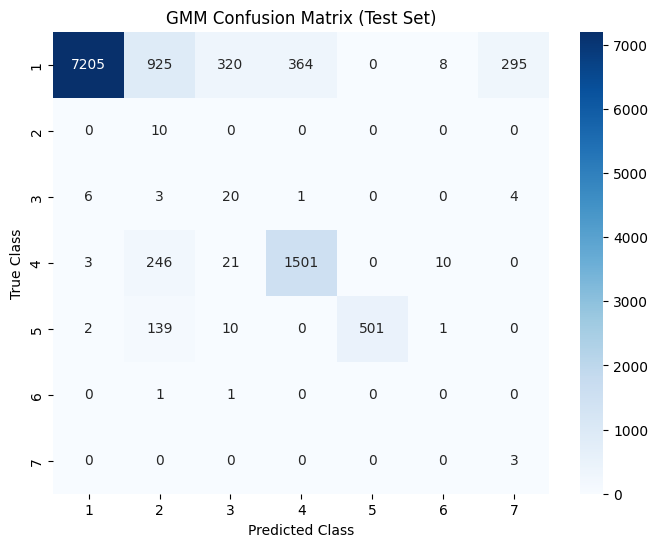

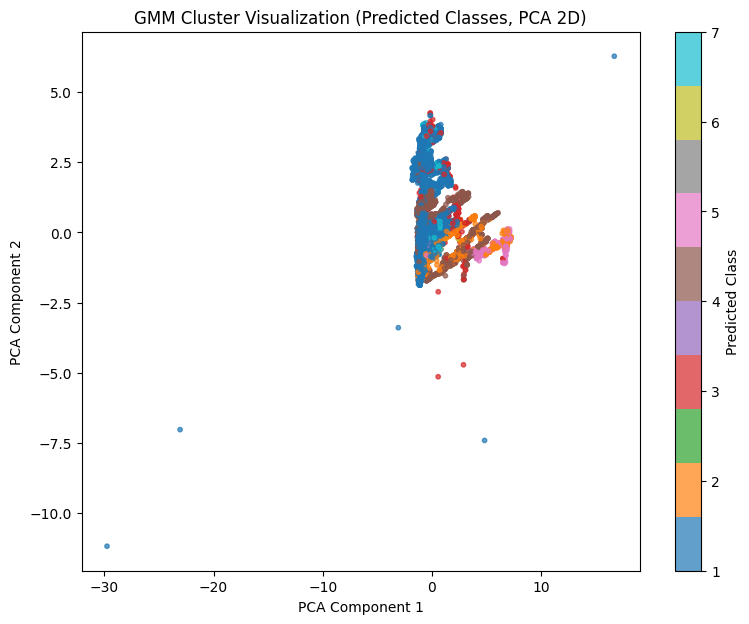

In [ ]:
#@title 🔵 BLOCK 5 — GMM PREDICT FUNCTION + EVALUATION
def gmm_predict_from_dict(gmms_dict, X_scaled):
    classes_list = sorted(gmms_dict.keys())
    scores = np.vstack([gmms_dict[c].score_samples(X_scaled) for c in classes_list]).T
    preds_idx = np.argmax(scores, axis=1)
    return np.array([classes_list[i] for i in preds_idx]), scores

y_pred_test, test_scores = gmm_predict_from_dict(gmms_sh, X_test_s)

acc = accuracy_score(y_test, y_pred_test)
print("GMM Classification Accuracy:", acc)
print("\nClassification report:\n", classification_report(y_test, y_pred_test))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_test))

#Plots
#@title 🟣 BLOCK 5A — CONFUSION MATRIX HEATMAP
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test, labels=sorted(gmms_sh.keys()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(gmms_sh.keys()),
            yticklabels=sorted(gmms_sh.keys()))

plt.title("GMM Confusion Matrix (Test Set)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

#@title 🟣 BLOCK 5B — GMM VISUALIZATION USING PCA (2D PROJECTION)
from sklearn.decomposition import PCA

#Reduce 7D Shuttle data → 2D for plotting
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_s)

plt.figure(figsize=(9,7))
scatter = plt.scatter(
    X_test_2d[:, 0], X_test_2d[:, 1],
    c=y_pred_test, cmap='tab10', s=10, alpha=0.7
)

plt.title("GMM Cluster Visualization (Predicted Classes, PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Predicted Class")
plt.show()



In [ ]:
#@title 🔵 BLOCK 6 — CREATE MATCHED EXTERNAL EXAMPLE DATASET
# Kindly note that the features names, order of features and dimensions in this example dataset is same as in the original dataset
means = X.mean()
stds  = X.std().replace(0, 1.0)

rows = [(means + np.random.randn(len(means)) * stds).values for _ in range(10)]
example_df = pd.DataFrame(rows, columns=list(X.columns))

EXAMPLE_CSV = "/content/external_data_example_matched.csv"
example_df.to_csv(EXAMPLE_CSV, index=False)

print("Created example:", EXAMPLE_CSV)
print(example_df.head())


Created example: /content/external_data_example_matched.csv
     Rad Flow  Fpv Close   Fpv Open        High     Bypass  Bpv Close  \
0   92.509164  25.006829   7.812583 -135.401795  46.646650  42.413635   
1   81.085257 -40.006896  52.410777 -236.558468  48.585677  88.737765   
2  101.281631   1.318940  31.482263  -75.850092  42.508076  76.290877   
3   80.485705 -62.995071  16.458084  159.837077  45.730140  58.721048   
4   86.962512  -4.471324  53.140848   56.603111  48.824090  37.810748   

    Bpv Open  
0  20.245361  
1 -30.182230  
2  43.823787  
3 -24.666692  
4  14.378284  


In [ ]:
#@title 🔵 BLOCK 7 — EXTERNAL PREDICTION WITH GMM
EXAMPLE_CSV = "/content/external_data_example_matched.csv"
OUT_PRED = "/content/output/external_gmm_predictions_matched.csv"

scaler = joblib.load("/content/output/scaler_gmm_shuttle.joblib")
gmms   = joblib.load("/content/output/gmm_class_model_shuttle.joblib")

df_ext = pd.read_csv(EXAMPLE_CSV)
X_ext_s = scaler.transform(df_ext)

preds, scores = gmm_predict_from_dict(gmms, X_ext_s)

df_out = df_ext.copy()
df_out["predicted_class"] = preds
df_out.to_csv(OUT_PRED, index=False)

print("Saved predictions to:", OUT_PRED)
print(df_out.head())

scores_df = pd.DataFrame(scores, columns=[str(c) for c in sorted(gmms.keys())])
print("\nPer-class log-likelihoods (first 5 rows):")
print(scores_df.head())


Saved predictions to: /content/output/external_gmm_predictions_matched.csv
     Rad Flow  Fpv Close   Fpv Open        High     Bypass  Bpv Close  \
0   92.509164  25.006829   7.812583 -135.401795  46.646650  42.413635   
1   81.085257 -40.006896  52.410777 -236.558468  48.585677  88.737765   
2  101.281631   1.318940  31.482263  -75.850092  42.508076  76.290877   
3   80.485705 -62.995071  16.458084  159.837077  45.730140  58.721048   
4   86.962512  -4.471324  53.140848   56.603111  48.824090  37.810748   

    Bpv Open  predicted_class  
0  20.245361                1  
1 -30.182230                1  
2  43.823787                3  
3 -24.666692                4  
4  14.378284                1  

Per-class log-likelihoods (first 5 rows):
             1             2             3            4            5  \
0 -1867.854778 -1.991195e+05  -4710.053273 -2385.308852 -4357.652898   
1 -7046.004080 -5.089619e+05 -12187.438756 -8258.479613 -9996.357926   
2  -203.571144 -1.120312e+03   -187